In [11]:
from keras.models import load_model
import pandas
import numpy as np
from keras import backend as K
import cv2
import matplotlib.pyplot as plt

- 加载已经训练好的模型

In [12]:
#绘制区域相关的函数

def mask2rle(img): 
    pixels= img.T.flatten() 
    pixels = np.concatenate([[0], pixels, [0]]) 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 
    runs[1::2] -= runs[::2] 
    return ' '.join(str(x) for x in runs) 

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    #shape = input_shape[:2] #(256,1600)
    
    mask= np.zeros( width*height ).astype(np.uint8) 
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    
    starts -= 1 #因为起始值是1，所以先要把坐标减一下
    ends = starts + lengths
    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1 
        
    return mask.reshape(height, width).T


def build_masks(rles, classid, input_shape): 
    depth = 4
    #print(depth)
    height, width = input_shape
    #print(input_shape)
    masks = np.zeros((height, width, depth))
    for i, rle in enumerate(rles):
        if type(rle) is str: #因为如果没有rle数据的话，该单元格的数据是nan，即浮点型
            masks[:, :, classid[i]-1] = rle2mask(rle, input_shape) 
    
    return masks

def build_rles(masks): 
    width, height, depth = masks.shape    
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]    
    return rles


In [13]:
smooth = 1.
 
#结果评估函数difference Coefficient 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#损失函数difference Coefficient loss
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
 
# load model 
model = load_model('../models/modelVGG16+resnet50.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [14]:
#获取图片的灰度图
def __load_grayscale(img_path):
    try:
        si = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #print(img)
        im = si.astype(np.float32) / 255.
        img = np.expand_dims(im, axis=-1)
    except:
        img = 0
        print(img_path)#因为有些图片因为图片本身的问题无法获取到他的灰度图，这样的图片属于脏数据，所以我们选择将报错信息转化为该图片的路径
    return img

In [15]:
#初始化检测单张图片的X
X = np.empty((1, 256, 1600, 1)) 

In [16]:
filename = '0bb3b11e1.jpg'
img_path = "./other/severstal-steel-defect-detection/train_images/{}".format(filename)
image = __load_grayscale(img_path)
for i  in range(256):
    X[0,i] = image[i]
a = model.predict(X)
a = a.round().astype(int)
#查看缺陷区域范围
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

sample_img = cv2.imread("./other/severstal-steel-defect-detection/train_images/{}".format(filename),-1)

fig, axs = plt.subplots(5, figsize=(12, 12))
#print(axs)
axs[0].imshow(sample_img)
axs[0].axis('on')

for i in range(4):
    axs[i+1].imshow(a[0, :, :, i])
    axs[i+1].axis('on')

./other/severstal-steel-defect-detection/train_images/0bb3b11e1.jpg


TypeError: 'int' object is not subscriptable

TypeError: Image data of dtype object cannot be converted to float

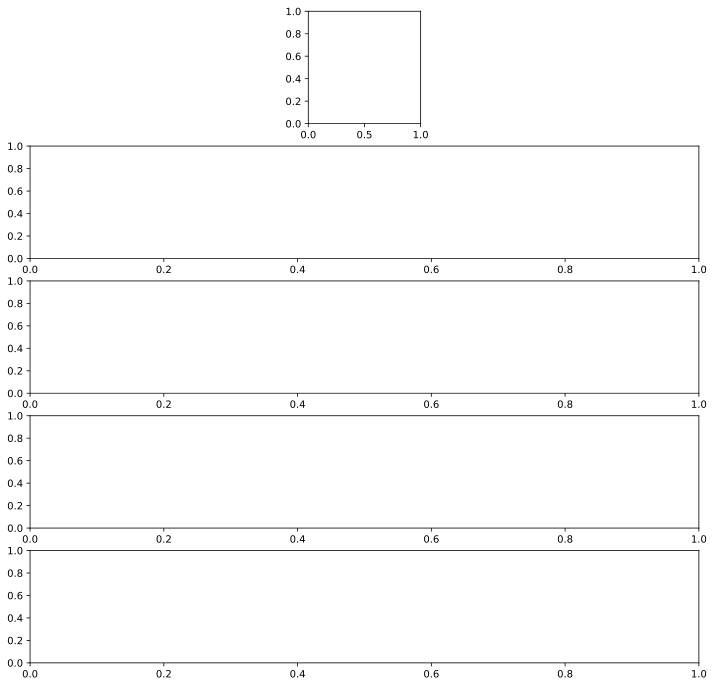

In [31]:
#查看缺陷区域范围
%matplotlib inline
%config InlineBackend.figure_format = 'svg'




t_img_name ='dc6028399.jpg'
'''sample_image_df = train_df[train_df['ImageId'] == t_img_name]'''
sample_path = "./other/severstal-steel-defect-detection/train_images/{}".format(t_img_name)
sample_img = cv2.imread(sample_path,cv2.IMREAD_GRAYSCALE)
'''#sample_img = cv2.imdecode(np.fromfile(sample_path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
sample_classid=list(sample_image_df['ClassId'])
sample_rles = sample_image_df['EncodedPixels'].values'''
#sample_masks = build_masks(sample_rles, sample_classid, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
#print(axs)
axs[0].imshow(sample_img)
axs[0].axis('on')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('on')